#### Student Number A00279668

### Load the libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")
import keras
import tensorflow as tf
import seaborn as sns

### Import the dataset

In [2]:
# import the dataset
df = pd.read_excel('preparedData.xlsx')

In [3]:
df.head()

,new_cases_smoothed,reproduction_rate,new_tests,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,...,book covid test: (Ireland)_y,covid test dublin: (Ireland),covid test centre: (Ireland),hse covid vaccine: (Ireland),hse vaccine portal: (Ireland),hse portal vaccine: (Ireland),pcr test hse: (Ireland),hse covid test: (Ireland),hse vaccine registration: (Ireland),how long will it take to vaccinate ireland: (Ireland)
0,15.714,2.51,0,0.0,0.0,0,0,0,0,0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,21.143,2.59,0,0.0,0.0,0,0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,27.000,2.70,0,0.0,0.0,0,0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,35.571,2.78,0,0.0,0.0,0,0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,73.429,2.84,946,0.0,0.0,0,0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
df.shape

(702, 49)

### Split the data into training and test sets

y = raw['new_cases_smoothed'].copy()
x = raw.drop('new_cases_smoothed', axis=1)

### Time shift the dataset

# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = x.values
data = series_to_supervised(values)

df_shifted = pd.DataFrame(data)

df_shifted.drop(columns=[])

In [5]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

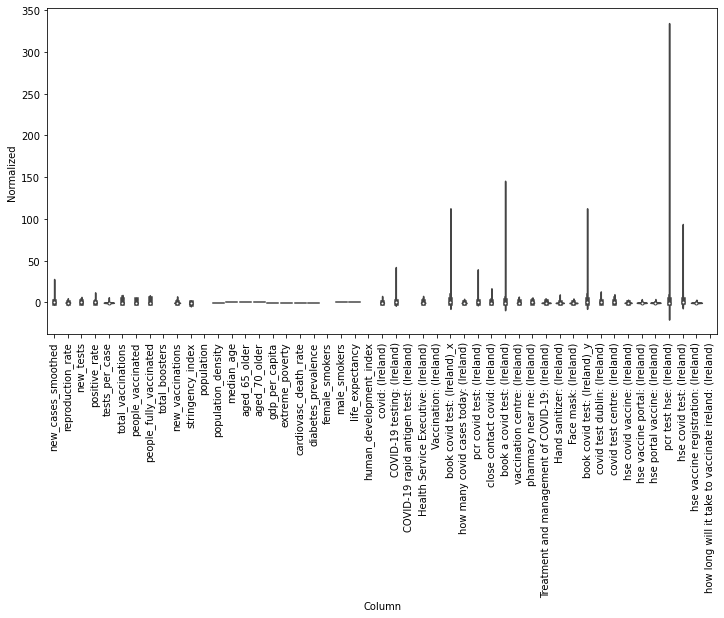

In [9]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [10]:
df.shape

(702, 49)

In [14]:
# https://www.tensorflow.org/tutorials/structured_data/time_series
# class WindowGenerator():
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
    
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
    
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
    
        self.total_window_size = input_width + shift
    
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    

In [15]:
w1 = WindowGenerator(input_width=49, label_width=1, shift=1,
                     label_columns=['new_cases_smoothed'])
w1

Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
Label indices: [49]
Label column name(s): ['new_cases_smoothed']

In [ ]:
#https://www.tensorflow.org/tutorials/structured_data/time_series 
# GOT UPTO DATA WINDOWING

### Principal Component Analysis

In [ ]:
pca = PCA(n_components=3)
x_reshaped = pca.fit_transform(x_scaled)
print('PCA X shape', x_reshaped.shape)
print('A lot of informaiton is lost: ', pca.explained_variance_ratio_)

fig = plt.figure()
ax = plt.axes(projection='3d')

for point in x_reshaped:
    ax.scatter3D(point[0], point[1], point[2], marker='o', cmap='hsv')
plt.show()

In [ ]:
pca = PCA()
pca.fit(x)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=0.95)+1
print("The minimum dimensions are:", d)

### Using Support Vector Classifier with PCA

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_reshaped, y, test_size = 0.3,
                              random_state=300)

In [ ]:
svc = SVC(class_weight = "balanced", kernel='linear', C=10.0)

In [ ]:
cv = cross_val_score(svc, x_train, y_train, cv=5)
cv_mean = cv.mean()
cv_std = cv.std()

In [ ]:
print("Cross Validation Values are: ", cv)
print(f"Average CV value is: {cv_mean:.4f}")
print(f"The Standard Deviation is: {cv_std:.4f}")

In [ ]:
svc_model = svc.fit(x_train, y_train)

In [ ]:
score = svc.score(x_test, y_test)

In [ ]:
y_pred = svc_model.predict(x_test)

In [ ]:
acc = accuracy_score(y_test, y_pred)
rep = classification_report(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='macro')


In [ ]:
print(f"The accuracy score on the test set is: {acc:.4f}")
print("\nHere is the classification report: \n",rep)
print(f"The precision score is: {pre: .4f}")
print(f"The recall score is: {rec:.4f}")


In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))

In [ ]:
print("-"*40)
print("CONFUSION MATRIX with PCA")
print("-"*40)
print(cm)